# Data Path Locations

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setting paths for Corpus input
corpus_path = '/content/drive/MyDrive/IST 664 Project/Data/kagglemoviereviews/corpus/'

# Setting paths for JSON output
output_path = '/content/drive/MyDrive/IST 664 Project/Output_Files/'

# Path to the Subjectivity Lexicon
SLpath = r'/content/drive/MyDrive/IST 664 Project/Data/kagglemoviereviews/SentimentLexicons/subjclueslen1-HLTEMNLP05.tff'

# Path to the LIWC negative and positive dictionary
liwc_path = '/content/drive/MyDrive/IST 664 Project/Data/kagglemoviereviews/SentimentLexicons/liwcdic2007.dic'

# Path to the Harvard Inquirer lexicon
inquirer_path = '/content/drive/MyDrive/IST 664 Project/Data/kagglemoviereviews/SentimentLexicons/inquirerbasic.csv'

# Libraries

In [4]:
# Data Processing and General Libraries
import os
import sys
import random
import pandas as pd
import json
import timeit

# Text Processing Libraries
import nltk
from nltk.corpus import stopwords
import re
from string import punctuation
from nltk.corpus import sentence_polarity
from nltk.collocations import * # Bigram Features

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Classifiers
from sklearn.metrics import accuracy_score
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import  BernoulliNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# NLTK Downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentence_polarity')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentence_polarity to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package sentence_polarity is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Import Functions

In [5]:
# This function returns a dictionary to look up words and get back the four items of subjectivity information
def readSubjectivity(path):
	# Read in the lexicon
	flexicon = open(path, 'r')
	# Initialize an empty dictionary
	sldict = { }
	# Loop through lexicon
	for line in flexicon:
		# Split the file by whitespaces
		fields = line.split()
		# Split on the equal sign and take the first item for the four items of subjectivity information
		strength = fields[0].split("=")[1]
		word = fields[2].split("=")[1]
		posTag = fields[3].split("=")[1]
		stemmed = fields[4].split("=")[1]
		polarity = fields[5].split("=")[1]
		# Create true and false tags for stemmed words
		if (stemmed == 'y'):
			isStemmed = True
		else:
			isStemmed = False
		# Create a dictionary entry with the word as the keyword and a list of the other values
		sldict[word] = [strength, posTag, isStemmed, polarity]
	return sldict

In [6]:
# Returns a list of positive words and a list of negative words
def read_words(lex_path):
  # Creating empty lists
  poslist = []
  neglist = []
  # Read in the lexicon
  flexicon = open(lex_path, encoding='latin1')
  # Read in all LIWC words
  wordlines = [line.strip() for line in flexicon]
  # each line has a word or a stem followed by * and numbers of the word classes it is in
  # word class 126 is positive emotion and 127 is negative emotion
  for line in wordlines:
    if not line == '':
      items = line.split()
      word = items[0]
      classes = items[1:]
      for c in classes:
        if c == '126':
          poslist.append( word )
        if c == '127':
          neglist.append( word )
  return (poslist, neglist)

In [7]:
# test to see if a word is in LIWC positive and negative lists
# using a prefix test if the word is a stem with an *
# returns True or False
def isPresent(word, emotionlist):
  isFound = False
  # loop over all elements of list
  for emotionword in emotionlist:
    # test if a word or a stem
    if not emotionword[-1] == '*':
      # it's a word!
      # when a match is found, can quit the loop with True
      if word == emotionword:
        isFound = True
        break
    else:
      # it's a stem!
      # when a match is found, can quit the loop with True
      if word.startswith(emotionword[0:-1]):
        isFound = True
        break
  # end of loop
  return isFound

In [8]:
# Read in the Harvard Inquirer lexicon and idnetify strength and polarity for each word
def read_inquirer(path):
  # Read in the lexicon
  inquirer = open(path, 'r')
  # Create blank dictionary
  inquirer_dict = {}
  # Loop through lexicon and split out word, positive, negative, and strength values
  for line in inquirer:
    # Finding the word
    fields = line.split(',')
    word = fields[0].split('#')[0]
    # Finding the polarity
    pos_tag = fields[2]
    neg_tag = fields[3]
    polarity = pos_tag+neg_tag
    # Finding the strength
    strength_tag = fields[8]
    weak_tag = fields[10]
    strength = strength_tag + weak_tag
    # Adding the word as a key to the dictionary and polarity and strength as values
    inquirer_dict[word] = [polarity,strength]
  return inquirer_dict

In [9]:
# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output: returns lists of precision, recall and F1 for each label
#      (for computing averages across folds and labels)
def eval_measures(gold, predicted, labels):
    
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []

    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        # for small numbers, guard against dividing by zero in computing measures
        if (TP == 0) or (FP == 0) or (FN == 0):
          recall_list.append (0)
          precision_list.append (0)
          F1_list.append(0)
        else:
          recall = TP / (TP + FP)
          precision = TP / (TP + FN)
          recall_list.append(recall)
          precision_list.append(precision)
          F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    return (precision_list, recall_list, F1_list)

In [172]:
## cross-validation ##
# this function takes the number of folds, the feature sets and the labels
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the performance for each fold and the average performance at the end
def cross_validation_PRF(num_folds, train_featuresets, test_featuresets, labels, classifier_model):
    subset_size_train = int(len(train_featuresets)/num_folds)
    subset_size_test = int(len(test_featuresets)/num_folds)
    print('Each fold size for train:', subset_size_train)
    print('Each fold size for test:', subset_size_test)

    # for the number of labels - start the totals lists with zeroes
    num_labels = len(labels)
    total_precision_list = [0] * num_labels
    total_recall_list = [0] * num_labels
    total_F1_list = [0] * num_labels

    # iterate over the folds
    for i in range(num_folds):
        # test_this_round = train_featuresets[(i*subset_size_train):][:subset_size_train]
        # train_this_round = test_featuresets[:(i*subset_size_test)] + test_featuresets[((i+1)*subset_size_test):]
        # train using train_this_round
        classifier = classifier_model.train(train_featuresets)
        # evaluate against test_this_round to produce the gold and predicted labels
        goldlist = []
        predictedlist = []
        for (features, label) in test_featuresets:
            goldlist.append(label)
            predictedlist.append(classifier.classify(features))

        # computes evaluation measures for this fold and
        #   returns list of measures for each label
        print('Fold', i)
        (precision_list, recall_list, F1_list) \
                  = eval_measures(goldlist, predictedlist, labels)
        # take off triple string to print precision, recall and F1 for each fold
        '''
        print('\tPrecision\tRecall\t\tF1')
        # print measures for each label
        for i, lab in enumerate(labels):
            print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
              "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
        '''
        # for each label add to the sums in the total lists
        for i in range(num_labels):
            # for each label, add the 3 measures to the 3 lists of totals
            total_precision_list[i] += precision_list[i]
            total_recall_list[i] += recall_list[i]
            total_F1_list[i] += F1_list[i]

    # find precision, recall and F measure averaged over all rounds for all labels
    # compute averages from the totals lists
    precision_list = [tot/num_folds for tot in total_precision_list]
    recall_list = [tot/num_folds for tot in total_recall_list]
    F1_list = [tot/num_folds for tot in total_F1_list]
    # the evaluation measures in a table with one row per label
    print('\nAverage Precision\tRecall\t\tF1 \tPer Label')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
    
    # print macro average over all labels - treats each label equally
    print('\nMacro Average Precision\tRecall\t\tF1 \tOver All Labels')
    print('\t', "{:10.3f}".format(sum(precision_list)/num_labels), \
          "{:10.3f}".format(sum(recall_list)/num_labels), \
          "{:10.3f}".format(sum(F1_list)/num_labels))

    # for micro averaging, weight the scores for each label by the number of items
    #    this is better for labels with imbalance
    # first intialize a dictionary for label counts and then count them
    label_counts = {}
    featuresets = train_set + test_set
    for lab in labels:
      label_counts[lab] = 0 
    # count the labels
    for (doc, lab) in featuresets:
      label_counts[lab] += 1
    # make weights compared to the number of documents in featuresets
    num_docs = len(featuresets)
    label_weights = [(label_counts[lab] / num_docs) for lab in labels]
    print('\nLabel Counts', label_counts)
    #print('Label weights', label_weights)
    # print macro average over all labels
    print('Micro Average Precision\tRecall\t\tF1 \tOver All Labels')
    precision = sum([a * b for a,b in zip(precision_list, label_weights)])
    recall = sum([a * b for a,b in zip(recall_list, label_weights)])
    F1 = sum([a * b for a,b in zip(F1_list, label_weights)])
    print( '\t', "{:10.3f}".format(precision), \
      "{:10.3f}".format(recall), "{:10.3f}".format(F1))

# Step 1: Text Processing

### Primary Sentences

In [120]:
def import_sentence(corpus_path):
    # Reading in the corpus
    df_train = pd.read_csv(corpus_path, sep='\t')

    # Grouping by the sentenceId and taking the first sentence
    df_train = df_train.groupby('SentenceId').first().reset_index()

    # Creating an empty list for the review data
    review_data_sentence = []
    
    # Looping through each line in the dataframe
    for i, row in df_train['Phrase'].items():
      # Removing whitespace in each line
      row = row.strip()
      # Finding sentiment rating
      sentiment_rating = df_train.at[i, 'Sentiment']
      # Combine row and sentiment
      phrase_sentiment = row + '\t' + str(sentiment_rating)
      # Splitting each line by the separator and taking the phrase and sentiment
      review_data_sentence.append(phrase_sentiment.split('\t')[0:2])
    
    # Shuffling the data for randomized documents
    random.Random(3).shuffle(review_data_sentence)

    # Defining a document limit
    #sentence_list = review_data_sentence[:phrase_limit]

    # Printing amount of phrases in data
    print(f'Amount of phrases in sentence data: {len(review_data_sentence)}')

    # Returning the processed data
    return review_data_sentence

### Full Data

In [121]:
def import_full(corpus_path):
  # Read in the training data
  f = open(corpus_path, 'r')

  # Creating an empty list for the review data
  review_data_full = []

  # Looping through each line in the file
  for line in f:
    # Cutting out the phrase and sentiment
    if not 'Phrase' in line:
      # Removing whitespace in each line
      line = line.strip()
      # Splitting each line by the separator and taking the phrase and sentiment
      list_data = line.split('\t')[2:4]
      # Adding the phrase and sentiment to a list
      review_data_full.append(list_data)

  # Closing the file
  f.close()

  # Shuffling the data for randomized documents
  random.Random(3).shuffle(review_data_full)

  # Defining a document limit
  #full_list = review_data_full[:phrase_limit]

  # Printing amount of phrases in data
  print(f'Amount of phrases in sentence data: {len(review_data_full)}')

  # Returning the processed data
  return review_data_full

### Output Tokenized Data

In [122]:
def process_text(phrase_list):
  # Creating an empty list for the tokenized data
  token_list_full = []

  # Creating a list of punctuation
  punct_list = list(punctuation)

  # Loop through data to tokenize, make all lowercase, and expand contractions
  for phrase in phrase_list:
    # Tokenize
    tokens = nltk.word_tokenize(phrase[0])
    # Lowercase
    tokens = [w.lower( ) for w in tokens]
    # Remove puncutation
    tokens = [token for token in tokens if token not in punct_list]
    # Add to list
    if len(tokens) > 1:
      token_list_full.append((tokens, int(phrase[1])))

  # Printing amount of phrases in data
  print(f'Random data used: {len(token_list_full)}')

  # Returning the tokenized data
  return token_list_full

### Filtered and Tokenized Text

In [123]:
def filter_text(phrase_list):
  # Creating an empty list for the tokenized and filtered data
  token_filtered_list = []

  # Creating a list of punctuation
  punct_list = list(punctuation)

  # Creating a pattern to match to remove non-alphabetic characters
  pattern = re.compile(r'^[^a-z]+$')

  # Getting NLTK standard stopwords
  stop_words = nltk.corpus.stopwords.words('english')
  # Creating a list of additional stopwords
  more_stopwords = ['can','has','have','had','must','shan','do', 'should','was',
                    'were','won','are','cannot','does','could','did','is','might',
                    'need','would', "'s", 'film', 'movie', 'story', '-rrb-', '-lrb-',
                    "'re", "n't"]
  negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 
                   'rather', 'hardly', 'scarcely', 'rarely', 'seldom', 'neither', 
                   'nor','ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 
                   'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 
                   'shouldn', 'wasn', 'weren', 'won', 'wouldn']

  # Combining stopword lists
  complete_stopwords = stop_words + more_stopwords
  complete_stopwords = [word for word in complete_stopwords if word not in negationwords]

  # Loop through data to tokenize, make all lowercase, and expand contractions
  for phrase in phrase_list:
    # Tokenize
    tokens = nltk.word_tokenize(phrase[0])
    # Lowercase
    tokens = [w.lower( ) for w in tokens]
    # Remove puncutation
    tokens = [token for token in tokens if token not in punct_list]
    # Remove Non-alphabetical characters
    tokens = [token for token in tokens if not pattern.match(token)]
    # Remove words under two characters
    tokens = [token for token in tokens if len(tokens) > 2]
    # Remove stopwords
    tokens = [token for token in tokens if not token in complete_stopwords]
    # Add to list
    if len(tokens) > 1:
      token_filtered_list.append((tokens, int(phrase[1])))

  # Printing amount of phrases in data
  print(f'Random data used: {len(token_filtered_list)}')
  
  # Returning the tokenized and filtered data
  return token_filtered_list

##### Refining Stopwords - Full Data

In [124]:
def word_list(phrase_list):
  all_words_list = [word for (sent,cat) in phrase_list for word in sent]
  all_words = nltk.FreqDist(all_words_list)
  word_items = all_words.most_common(2000)
  return word_items

In [125]:
full_word_list = word_list(filter_text(import_full(corpus_path+'train.tsv')))
#sentence_word_list = process_text(import_sentence(corpus_path+'train.tsv'))

Amount of phrases in sentence data: 156060
Random data used: 103527


2000


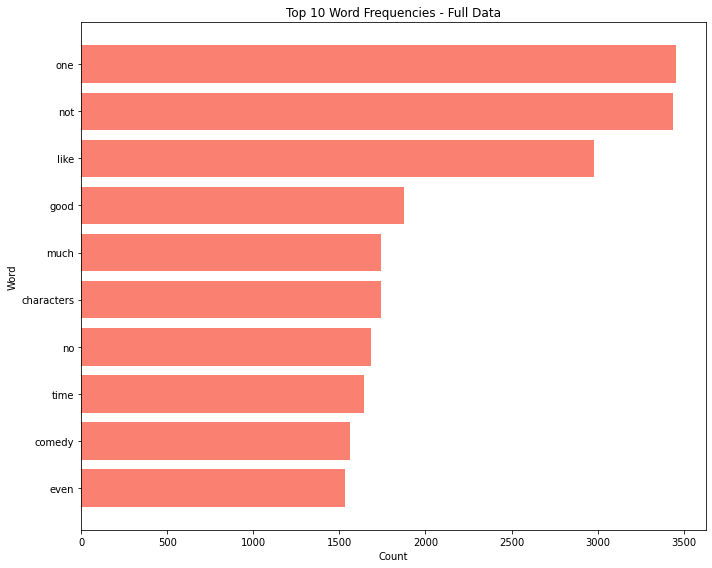

In [126]:
word_list = [word for (word,count) in full_word_list]
freq_list = [count for (word,count) in full_word_list]

# create dataframe
df = pd.DataFrame({'Words': word_list, 'Frequencies': freq_list}).sort_values('Frequencies', ascending=False)
print(len(df['Frequencies']))

fig = plt.figure(figsize = (10, 8))
 
# creating the bar plot
plt.barh('Words', 'Frequencies', data=df.head(10).sort_values('Frequencies', ascending=True), color ='salmon')#, height = 0.4)
 
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 10 Word Frequencies - Full Data')
fig.tight_layout()
#plt.show()
plt.savefig(output_path+'Full_Data_Word_Freq.png')

In [127]:
del full_word_list
del word_list
del freq_list
del df

##### Refining Stopwords - Sentence Data

In [128]:
def word_list(phrase_list):
  all_words_list = [word for (sent,cat) in phrase_list for word in sent]
  all_words = nltk.FreqDist(all_words_list)
  word_items = all_words.most_common(2000)
  return word_items

In [129]:
sentence_word_list = word_list(filter_text(import_sentence(corpus_path+'train.tsv')))

Amount of phrases in sentence data: 8529
Random data used: 8261


2000


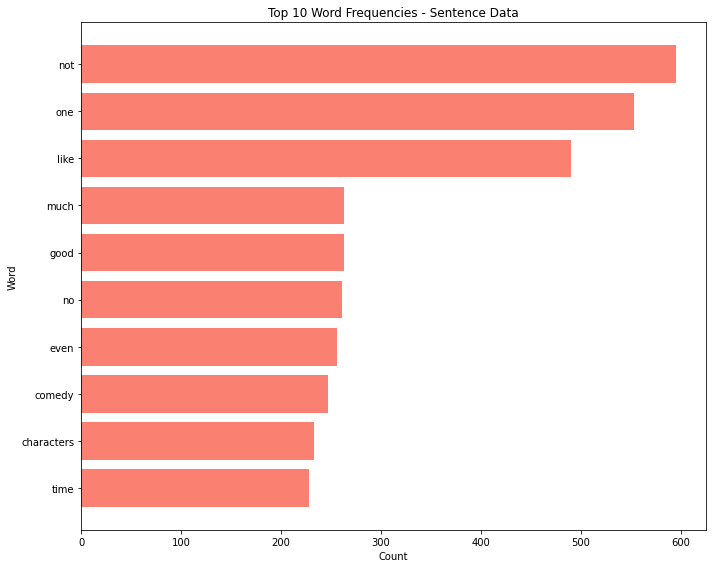

In [130]:
word_list = [word for (word,count) in sentence_word_list]
freq_list = [count for (word,count) in sentence_word_list]

# create dataframe
df = pd.DataFrame({'Words': word_list, 'Frequencies': freq_list}).sort_values('Frequencies', ascending=False)
print(len(df['Frequencies']))

fig = plt.figure(figsize = (10, 8))
 
# creating the bar plot
plt.barh('Words', 'Frequencies', data=df.head(10).sort_values('Frequencies', ascending=True), color ='salmon')#, height = 0.4)
 
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 10 Word Frequencies - Sentence Data')
fig.tight_layout()
#plt.show()
plt.savefig(output_path+'Sentence_Data_Word_Freq.png')

In [131]:
del sentence_word_list
del word_list
del freq_list
del df

### Pre-processed and Tokenized Text

In [132]:
def preprocess_text(phrase_list):
  # Creating an empty list for the tokenized and pre-processed data
  token_preprocess_list = []

  # Creating a list of punctuation
  punct_list = list(punctuation)

  # Creating the stemmer using porter
  porter = nltk.PorterStemmer() #lancaster = nltk.LancasterStemmer()

  # Creating a lemmatizer using wordnetlemmatizer from NLTK
  word_lemma = nltk.WordNetLemmatizer()

  # Loop through data to tokenize, make all lowercase, and expand contractions
  for phrase in phrase_list:
    # Tokenize
    tokens = nltk.word_tokenize(phrase[0])
    # Lowercase
    tokens = [w.lower( ) for w in tokens]
    # Remove puncutation
    tokens = [token for token in tokens if token not in punct_list]
    # Stemming
    tokens = [porter.stem(token) for token in tokens]
    # Lemmatize
    tokens = [word_lemma.lemmatize(token) for token in tokens] 
    # Add to list
    if len(tokens) > 1:
      token_preprocess_list.append((tokens, int(phrase[1])))

  # Printing amount of phrases in data
  print(f'Random data used: {len(token_preprocess_list)}')

  # Returning the tokenized and pre-processed data
  return token_preprocess_list

### Filtered and Pre-processed Tokenized Text

In [133]:
def filter_preprocess_text(phrase_list):
  # Creating an empty list for the tokenized, pre-processed, and filtered data
  token_filtered_preprocess_list = []

  # Creating a list of punctuation
  punct_list = list(punctuation)

  # Creating the stemmer using porter
  porter = nltk.PorterStemmer() #lancaster = nltk.LancasterStemmer()

  # Creating a lemmatizer using wordnetlemmatizer from NLTK
  word_lemma = nltk.WordNetLemmatizer()

  # Creating a pattern to match to remove non-alphabetic characters
  pattern = re.compile(r'^[^a-z]+$')

  # Getting NLTK standard stopwords
  stop_words = nltk.corpus.stopwords.words('english')
  # Creating a list of additional stopwords
  more_stopwords = ['not', 'no', 'can','has','have','had','must','shan','do', 'should','was','were','won','are','cannot','does','ain', 'could', 'did', 'is', 'might', 'need', 'would']
  # Combining stopword lists
  complete_stopwords = stop_words + more_stopwords

  # Loop through data to tokenize, make all lowercase, and expand contractions
  for phrase in phrase_list:
    # Tokenize
    tokens = nltk.word_tokenize(phrase[0])
    # Lowercase
    tokens = [w.lower( ) for w in tokens]
    # Remove puncutation
    tokens = [token for token in tokens if token not in punct_list]
    # Remove Non-alphabetical characters
    tokens = [token for token in tokens if not pattern.match(token)]
    # Remove words under two characters
    tokens = [token for token in tokens if len(tokens) > 2]
    # Remove stopwords
    tokens = [token for token in tokens if not token in complete_stopwords]
    # Stemming
    tokens = [porter.stem(token) for token in tokens]
    # Lemmatize
    tokens = [word_lemma.lemmatize(token) for token in tokens] 
    # Add to list
    if len(tokens) > 1:
      token_filtered_preprocess_list.append((tokens, int(phrase[1])))

  # Printing amount of phrases in data
  print(f'Random data used: {len(token_filtered_preprocess_list)}')
  
  # Returning the tokenized, pre-processed, and filtered data
  return token_filtered_preprocess_list

### Final Output Dictionary

In [129]:
# Creating a dictionary for all processed text
processed_dict = {'all_token': process_text(import_full(corpus_path+'train.tsv'))[:1000],
                  'all_token_filter': filter_text(import_full(corpus_path+'train.tsv'))[:1000],
                  'all_token_preprocess': preprocess_text(import_full(corpus_path+'train.tsv'))[:1000],
                  'all_token_filter_preprocess': filter_preprocess_text(import_full(corpus_path+'train.tsv'))[:1000],
                  'sent_token': process_text(import_sentence(corpus_path+'train.tsv'))[:1000],
                  'sent_token_filter': filter_text(import_sentence(corpus_path+'train.tsv'))[:1000],
                  'sent_token_preprocess': preprocess_text(import_sentence(corpus_path+'train.tsv'))[:1000],
                  'sent_token_filter_preprocess': filter_preprocess_text(import_sentence(corpus_path+'train.tsv'))[:1000]}

Amount of phrases in sentence data: 156060
Random data used: 138234
Amount of phrases in sentence data: 156060
Random data used: 103527
Amount of phrases in sentence data: 156060
Random data used: 138234
Amount of phrases in sentence data: 156060
Random data used: 105625
Amount of phrases in sentence data: 8529
Random data used: 8476
Amount of phrases in sentence data: 8529
Random data used: 8261
Amount of phrases in sentence data: 8529
Random data used: 8476
Amount of phrases in sentence data: 8529
Random data used: 8309


In [130]:
# Checking for any blank items
for key, value in processed_dict.items():
  for i in range(0,len(value)):
    if len(value[i][0]) == 0:
      print(key,value[i][0])

In [131]:
# Writing dictionary to JSON file
with open(output_path+"processed_dict.json", "w") as outfile:
  json.dump(processed_dict, outfile)

In [132]:
# Removing dictionary after writing to JSON
del processed_dict

# Step 2: Feature Engineering

In [175]:
# Reading in dictionary
with open(output_path+"processed_dict.json", 'r') as infile:
    processed_dict = json.load(infile)

In [117]:
# Function to return word features for the top 1000 words
def word_features(documents):
  # Get all words from all movie reviews
  all_words_list = [word for (sent,cat) in documents for word in sent]
  # Put into a frequency distribution
  all_words = nltk.FreqDist(all_words_list)
  # Get the most frequently appearing keywords in the corpus
  word_items = all_words.most_common(1000)
  word_features = [word for (word,count) in word_items]
  return word_features

### Bag of Words Unigrams Features

In [135]:
# Function to build the BOW document features using a document and word features
def document_features(document, word_features):
  # Creating a set from the documents
  document_words = set(document)
  # Creating a blank dictionary to store features
  features = {}
  # Getting each word from the document and adding it to the features dictionary with word as key
  for word in word_features:
    features['V_{}'.format(word)] = (word in document_words)
  # Returning the features
  return features

In [136]:
# Creating the Bag of Words featureset
def bow_feature_set(dict_item):
  # Creating a timer
  start = timeit.default_timer()
  # Creating a blank dictionary
  bow_dict = {}
  # Looping through the features dictionary
  for key, value in dict_item.items():
    print('Currently Processing BOW Feature: ' + key)
    # Appending each word to the dictionary with true or false if it is in the dictionary
    bow_dict['bow_' + key] = [(document_features(d, word_features(value)), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()
  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')
  # Writing dictionary to JSON file
  with open(output_path+"bow_dict.json", "w") as outfile:
    json.dump(bow_dict, outfile)
  # Returning the featureset
  return bow_dict

### Bag of Words Bigrams Features



In [151]:
# Function to build the BOW document features using a document and word features
def bigram_features(documents):
  # Instantiating the bigram measure from NLTK
  bigram_measures = nltk.collocations.BigramAssocMeasures()
  # Getting a list of all the words
  all_words_list = [word for (sent,cat) in documents for word in sent]
  # Instantiating the bigram finder
  finder = BigramCollocationFinder.from_words(all_words_list)
  # Finding the top 1000 bigrams
  bigram_features = finder.nbest(bigram_measures.chi_sq, 1000)
  # Returning the bigrams
  return bigram_features

In [118]:
# Creating the bigram features with bag of words featureset
def bigram_bow_document_features(document, word_features, bigram_features):
  # Creating a set from the documents
  document_words = set(document)
  # Finding all bigrams
  document_bigrams = nltk.bigrams(document)
  # Creating a blank dictionary to store features
  features = {}
  # Getting each word from the document and adding it to the bigram features dictionary with word as key
  for word in word_features:
    features['V_{}'.format(word)] = (word in document_words)
  # Getting each bigram from the document and adding it to the bigram features dictionary with bigram as key
  for bigram in bigram_features:
    features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)
  # Returning the featureset 
  return features

In [139]:
# Creating the bigram with bag of words featureset
def bigram_bow_feature_set(dict_item):
  # Creating a timer
  start = timeit.default_timer()
  # Creating a blank dictionary
  bigram_bow_dict = {}
  # Looping through the features dictionary
  for key, value in dict_item.items():
    # if (key == 'all_token_filter') or (key == 'all_token_filter_preprocess'):
    #   continue
    print('Currently Processing Bigram BOW Feature: ' + key)
    bigram_bow_dict['bigrambow_' + key] = [(bigram_bow_document_features(d, word_features(value), bigram_features(value)), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()
  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')

  # Writing dictionary to JSON file
  with open(output_path+"bigram_bow_dict.json", "w") as outfile:
    json.dump(bigram_bow_dict, outfile)
  
  # Return dict
  return bigram_bow_dict

### Bigram Features

In [148]:
def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
    return features

In [149]:
def bigram_feature_set(dict_item):
  # Creating a timer
  start = timeit.default_timer()

  bigram_dict = {}
  for key, value in dict_item.items():
    # if (key == 'all_token_filter') or (key == 'all_token_filter_preprocess'):
    #   continue
    print('Currently Processing Bigram Feature: ' + key)
    bigram_dict['bigram_' + key] = [(bigram_document_features(d, word_features(value), bigram_features(value)), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()

  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')

  # Writing dictionary to JSON file
  with open(output_path+"bigram_dict.json", "w") as outfile:
    json.dump(bigram_dict, outfile)
  
  # Return dict
  return bigram_dict

### POS Features

In [142]:
# this function takes a document list of words and returns a feature dictionary
# it runs the default pos tagger (the Stanford tagger) on the document
#   and counts 4 types of pos tags to use as features
def pos_features(document, word_features):
  # Creating a set from the documents
  document_words = set(document)
  # Tagging the documents with POS tags
  tagged_words = nltk.pos_tag(document)
  # Creating a blank dictionary
  features = {}
  # Getting each word from the document and adding it to the features dictionary with word as key
  for word in word_features:
    features['contains({})'.format(word)] = (word in document_words)
  # Defining the POS tags
  numNoun = 0
  numVerb = 0
  numAdj = 0
  numAdverb = 0
  # Counting the words and their tags
  for (word, tag) in tagged_words:
    if tag.startswith('N'): numNoun += 1
    if tag.startswith('V'): numVerb += 1
    if tag.startswith('J'): numAdj += 1
    if tag.startswith('R'): numAdverb += 1
  # Returning the count of POS tags to a dictionary
  features['nouns'] = numNoun
  features['verbs'] = numVerb
  features['adjectives'] = numAdj
  features['adverbs'] = numAdverb
  # Returning dictionary with POS counts
  return features

In [143]:
# Creating the POS featureset
def pos_feature_set(dict_item):
  # Creating a timer
  start = timeit.default_timer()
  # Creating a blank dictionary
  pos_dict = {}
  # Looking for the POS for each word in word features for each document
  for key, value in dict_item.items():
    print('Currently Processing POS Feature: ' + key)
    pos_dict['pos_' + key] = [(pos_features(d, word_features(value)), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()
  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')

  # Writing dictionary to JSON file
  with open(output_path+"pos_dict.json", "w") as outfile:
    json.dump(pos_dict, outfile)
  
  # Return dict
  return pos_dict

### Negative Features

In [144]:
# List of negation words
negationwords = ['no', "n't", 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 
                  'rather', 'hardly', 'scarcely', 'rarely', 'seldom', 'neither', 
                  'nor','ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 
                  'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 
                  'shouldn', 'wasn', 'weren', 'won', 'wouldn']

In [145]:
# One strategy with negation words is to negate the word following the negation word
#   other strategies negate all words up to the next punctuation
# Strategy is to go through the document words in order adding the word features,
#   but if the word follows a negation words, change the feature to negated word
# Start the feature set with all 2000 word features and 2000 Not word features set to false
def NOT_features(document, word_features, negationwords):
  # Creating a blank dictionary
  features = {}
  # Getting each word from the word features and adding it to the features dictionary with word as key
  for word in word_features:
    features['V_{}'.format(word)] = False
    # Adding negative words from the word features and adding it to the features dictionary with word as key
    features['V_NOT{}'.format(word)] = False
  # Going through each document words in order and adding the negative and unigrams to dictionary
  for i in range(0, len(document)):
    word = document[i]
    if ((i + 1) < len(document)) and ((word in negationwords) or (word.endswith("n't"))):
      i += 1
      features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
    else:
      features['V_{}'.format(word)] = (word in word_features)

  return features

In [146]:
def negative_feature_set(dict_item):
  # Creating a timer
  start = timeit.default_timer()
  # Creating a blank dictionary
  negative_dict = {}
  # Going through all documents and applying the NOT features function
  for key, value in dict_item.items():
    print('Currently Processing Negative Feature: ' + key)
    negative_dict['negative_' + key] = [(NOT_features(d, word_features(value), negationwords), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()
  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')

  # Writing dictionary to JSON file
  with open(output_path+"negative_dict.json", "w") as outfile:
    json.dump(negative_dict, outfile)
  
  # Return dict
  return negative_dict

### Subjectivity Features

In [147]:
# define features that include word counts of subjectivity words
# negative feature will have number of weakly negative words +
#    2 * number of strongly negative words
# positive feature has similar definition
#    not counting neutral words
def SL_features(document, word_features, SL):
  # Creating a set from the documents
  document_words = set(document)
  # Creating a blank dictionary
  features = {}
  # Looping through each word in the word features
  for word in word_features:
    features['V_{}'.format(word)] = (word in document_words)
  # Count variables for the 4 classes of subjectivity
  weakPos = 0
  strongPos = 0
  weakNeg = 0
  strongNeg = 0
  # Counting the polarity and strengths for each word
  for word in document_words:
    if word in SL:
      strength, posTag, isStemmed, polarity = SL[word]
      if strength == 'weaksubj' and polarity == 'positive':
          weakPos += 1
      if strength == 'strongsubj' and polarity == 'positive':
          strongPos += 1
      if strength == 'weaksubj' and polarity == 'negative':
          weakNeg += 1
      if strength == 'strongsubj' and polarity == 'negative':
          strongNeg += 1
      # Adding the counts to a positive and negative dictionary
      features['positivecount'] = weakPos + (2 * strongPos)
      features['negativecount'] = weakNeg + (2 * strongNeg)      
  return features

In [148]:
def subjectivity_feature_set(dict_item):
  # Creating a timer
  start = timeit.default_timer()
  # Creating a blank dictionary
  subject_dict = {}
  # Going through all documents and applying the SL features function
  for key, value in dict_item.items():
    print('Currently Processing Subjectivity Feature: ' + key)
    subject_dict['subjectivity_' + key] = [(SL_features(d, word_features(value), readSubjectivity(SLpath)), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()
  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')

  # Writing dictionary to JSON file
  with open(output_path+"subject_dict.json", "w") as outfile:
    json.dump(subject_dict, outfile)
  
  # Return dict
  return subject_dict

### LIWC Features

In [149]:
# Function to identify the positive and negative counts of the word features
def liwc_features(document, word_features,poslist,neglist):
  # Creating a set from the documents
  document_words = set(document)
  features = {}
  for word in word_features:
    features['contains({})'.format(word)] = (word in document_words)
  # Starting count for positive and negative words
  pos = 0
  neg = 0
  # Looping through each word features in the documents and finding if it is in the LIWC pos and neg dictionary
  for word in document_words:
    if isPresent(word,poslist):
      pos += 1
    if isPresent(word,neglist):
      neg += 1
    features['positivecount'] = pos
    features['negativecount'] = neg

  # If the word is not in the positive and negative dictionary then set them to 0
  if 'positivecount' not in features:
    features['positivecount'] = 0
  if 'negativecount' not in features:
    features['negativecount'] = 0
    
  return features

In [150]:
def liwc_feature_set(dict_item, lex_path):
  # Creating a timer
  start = timeit.default_timer()
  pos_list, neg_list = read_words(lex_path)
  # Creating a blank dictionary
  liwc_dict = {}
  # Looping through each document word and finding if it is in the LIWC pos and neg dictionary
  for key, value in dict_item.items():
    print('Currently Processing LIWC Feature: ' + key)
    liwc_dict['liwc_' + key] = [(liwc_features(dict_item,word_features(value),pos_list,neg_list), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()
  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')

  # Writing dictionary to JSON file
  with open(output_path+"liwc_dict.json", "w") as outfile:
    json.dump(liwc_dict, outfile)

  # Return dict
  return liwc_dict

### Subjectivity with LIWC Features

In [151]:
# Function to combine Subjectivity and LIWC function features
def SL_liwc_features(doc, word_features, SL, poslist, neglist):
  document_words = set(doc)
  features = {}
  for word in word_features:
    features['contains({})'.format(word)] = (word in document_words)
  # count variables for the 4 classes of subjectivity
  weakPos = 0
  strongPos = 0
  weakNeg = 0
  strongNeg = 0
  for word in document_words:
    if isPresent(word,poslist):
      strongPos += 1
    elif isPresent(word,neglist):
      strongNeg += 1
    elif word in SL:
      strength, posTag, isStemmed, polarity = SL[word]
      if strength == 'weaksubj' and polarity == 'positive':
        weakPos += 1
      if strength == 'strongsubj' and polarity == 'positive':
        strongPos += 1
      if strength == 'weaksubj' and polarity == 'negative':
        weakNeg += 1
      if strength == 'strongsubj' and polarity == 'negative':
        strongNeg += 1
    features['positivecount'] = weakPos + (2 * strongPos)
    features['negativecount'] = weakNeg + (2 * strongNeg)
  
  if 'positivecount' not in features:
    features['positivecount']=0
  if 'negativecount' not in features:
    features['negativecount']=0      
  return features

In [152]:
def sl_liwc_feature_set(dict_item, lex_path):
  # Creating a timer
  start = timeit.default_timer()

  pos_list, neg_list = read_words(lex_path)

  sl_liwc_dict = {}
  # Looping through each document word and finding if it is in the LIWC pos and neg dictionary or SL lexicon and adding to dictionary
  for key, value in dict_item.items():
    print('Currently Processing LIWC Feature: ' + key)
    sl_liwc_dict['subjectivityliwc_' + key] = [(SL_liwc_features(dict_item,word_features(value),readSubjectivity(SLpath),pos_list,neg_list), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()
  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')

  # Writing dictionary to JSON file
  with open(output_path+"sl_liwc_dict.json", "w") as outfile:
    json.dump(sl_liwc_dict, outfile)
  
  # Return dict
  return sl_liwc_dict

### Harvard General Inquirer and IV-4

In [153]:
# Function to create features using the Harvard Inquirer lexicon
def inquirer_features(document, word_features, inquirer_dict):
  # Creating a set from the documents
  document_words = set(document)
  # Creating a blank dictionary
  features = {}
  # Looking for word features in the document
  for word in word_features:
    features['V_{}'.format(word)] = (word in document_words)
  # Count variables for the 4 classes of subjectivity
  weakPos = 0
  strongPos = 0
  weakNeg = 0
  strongNeg = 0
  # Finding counts for polarity and strength of all words in the document
  for word in document_words:
    if word in inquirer_dict:
      polarity,strength = inquirer_dict[word]
      if strength == 'Strong' and polarity == 'Positiv':
          strongPos += 1
      if strength == 'Weak' and polarity == 'Positiv':
          weakPos += 1
      if strength == 'Strong' and polarity == 'Negativ':
          strongNeg += 1
      if strength == 'Weak' and polarity == 'Negativ':
          weakNeg += 1
      features['positivecount'] = weakPos + (2 * strongPos)
      features['negativecount'] = weakNeg + (2 * strongNeg)      
  return features

In [154]:
def inquirer_feature_set(dict_item,path):
  # Creating a timer
  start = timeit.default_timer()
  # Creating a blank dictionary
  inquirer_dict = {}
  # Going through all documents and applying the inquirer features function
  for key, value in dict_item.items():
    print('Currently Processing Harvard General Inquisitor Feature: ' + key)
    inquirer_dict['inquirer_' + key] = [(inquirer_features(d, word_features(value), read_inquirer(path)), c) for (d, c) in value]

  # Ending the timer
  stop = timeit.default_timer()
  # Printing the length of running the cell in minutes
  print('Time: ', (stop - start), 'seconds')

  # Writing dictionary to JSON file
  with open(output_path+"inquirer_dict.json", "w") as outfile:
    json.dump(inquirer_dict, outfile)
  
  # Return dict
  return inquirer_dict

### Final Features Output

In [156]:
feature_dict = {}

feature_dict['bow_dict'] = bow_feature_set(processed_dict)
feature_dict['bigrambow_dict'] = bigram_bow_feature_set(processed_dict)
feature_dict['bigram_dict'] = bigram_feature_set(processed_dict)
feature_dict['pos_dict'] = pos_feature_set(processed_dict)
feature_dict['negative_dict'] = negative_feature_set(processed_dict)
feature_dict['subjectivity_dict'] = subjectivity_feature_set(processed_dict)
feature_dict['liwc_dict'] = liwc_feature_set(processed_dict, liwc_path)
feature_dict['subjectivityliwc_dict'] = sl_liwc_feature_set(processed_dict,liwc_path)
feature_dict['inquirer_dict'] = inquirer_feature_set(processed_dict,inquirer_path)

Currently Processing BOW Feature: all_token
Currently Processing BOW Feature: all_token_filter
Currently Processing BOW Feature: all_token_preprocess
Currently Processing BOW Feature: all_token_filter_preprocess
Currently Processing BOW Feature: sent_token
Currently Processing BOW Feature: sent_token_filter
Currently Processing BOW Feature: sent_token_preprocess
Currently Processing BOW Feature: sent_token_filter_preprocess
Time:  78.63353102600013 seconds
Currently Processing Bigram BOW Feature: all_token
Currently Processing Bigram BOW Feature: all_token_filter
Currently Processing Bigram BOW Feature: all_token_preprocess
Currently Processing Bigram BOW Feature: all_token_filter_preprocess
Currently Processing Bigram BOW Feature: sent_token
Currently Processing Bigram BOW Feature: sent_token_filter
Currently Processing Bigram BOW Feature: sent_token_preprocess
Currently Processing Bigram BOW Feature: sent_token_filter_preprocess
Time:  602.5232830929999 seconds
Currently Processing B

In [180]:
# Writing dictionary to JSON file
with open(output_path+"feature_dict.json", "w") as outfile:
  json.dump(feature_dict, outfile)

In [181]:
# Removing dictionary after writing to JSON
del processed_dict
del feature_dict

# Step 3: Experiments

### Classifier Models

In [32]:
# Reading in dictionary
with open(output_path+"feature_dict.json", 'r') as infile:
    feature_dict = json.load(infile)

In [33]:
model_dict = {'bayes':nltk.NaiveBayesClassifier,
              'logistic':SklearnClassifier(LogisticRegression(max_iter=1000)),
              'randomforest':SklearnClassifier(RandomForestClassifier()),
              'svc':SklearnClassifier(SVC()),
              'linearsvc':SklearnClassifier(LinearSVC(max_iter=5000)),
              'sgd':SklearnClassifier(SGDClassifier()),
              'bernoulli':SklearnClassifier(BernoulliNB()),
              'multinomial':SklearnClassifier(MultinomialNB()),
              'decisiontree':SklearnClassifier(DecisionTreeClassifier())}

In [34]:
def classifier_experiment(dict_item,classifier_model,classifier_name,train_test_split):
  # Creating a timer
  start = timeit.default_timer()

  classifier_dict = {}
  for key, value in dict_item.items():
    # print('Currently Processing: ' + key)
    train_num = int(len(value) * train_test_split)
    
    train_set, test_set = value[:train_num], value[train_num:]
    classifier = classifier_model.train(train_set)
    classifier_dict[classifier_name + '_' + key] = round(nltk.classify.accuracy(classifier, test_set), 4)

  return classifier_dict

In [38]:
model_output_dict = {}
train_test_split = 0.7

for key, value in feature_dict.items():
  print('Current Dictionary: '+ key)
  for model_name, classifier in model_dict.items():
    print('\tCurrent Model: '+ model_name)
    model_output_dict[model_name + '_' + key] = classifier_experiment(value,classifier,model_name,train_test_split)
    print(model_output_dict[model_name + '_' + key])
  model_output_dict

Current Dictionary: bigrambow_dict
	Current Model: bayes
{'bayes_bigrambow_all_token': 0.5033, 'bayes_bigrambow_all_token_filter': 0.4133, 'bayes_bigrambow_all_token_preprocess': 0.5067, 'bayes_bigrambow_all_token_filter_preprocess': 0.42, 'bayes_bigrambow_sent_token': 0.32, 'bayes_bigrambow_sent_token_filter': 0.3367, 'bayes_bigrambow_sent_token_preprocess': 0.3167, 'bayes_bigrambow_sent_token_filter_preprocess': 0.3533}
	Current Model: logistic
{'logistic_bigrambow_all_token': 0.5, 'logistic_bigrambow_all_token_filter': 0.4, 'logistic_bigrambow_all_token_preprocess': 0.52, 'logistic_bigrambow_all_token_filter_preprocess': 0.4267, 'logistic_bigrambow_sent_token': 0.3233, 'logistic_bigrambow_sent_token_filter': 0.3367, 'logistic_bigrambow_sent_token_preprocess': 0.3467, 'logistic_bigrambow_sent_token_filter_preprocess': 0.3433}
	Current Model: randomforest
{'randomforest_bigrambow_all_token': 0.47, 'randomforest_bigrambow_all_token_filter': 0.3867, 'randomforest_bigrambow_all_token_pre

In [47]:
# Writing dictionary to JSON file
with open(output_path+"model_output_dict.json", "w") as outfile:
  json.dump(model_output_dict, outfile)

### Model Visuals and Tables

In [ ]:
values = {}

for key, value in model_output_dict.items():
  for key, value in model_output_dict[key].items():
    values[key] = value

features = list(values.keys())
feature_values = list(values.values())

# create dataframe
df = pd.DataFrame({'Featureset': features, 'Accuracy': feature_values}).sort_values('Accuracy', ascending=False)

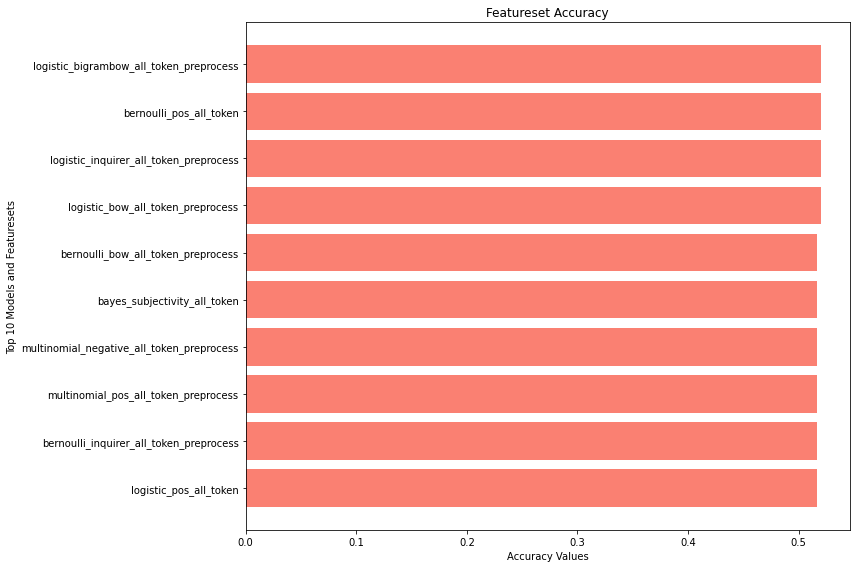

In [69]:
fig = plt.figure(figsize = (12, 8))
 
# creating the bar plot
plt.barh('Featureset', 'Accuracy', data=df.head(10).sort_values('Accuracy', ascending=True), color ='salmon')#, height = 0.4)
 
plt.xlabel('Accuracy Values')
plt.ylabel('Top 10 Models and Featuresets')
plt.title('Featureset Accuracy')
fig.tight_layout()
#plt.show()
plt.savefig(output_path+'Top_10_Models.png')

In [50]:
df_backup = df.copy()

In [59]:
# Creating a loop to extract department, sub department, and item from category code
for i, row in df['Featureset'].items():

  cat_list = row.split('_')

  if len(cat_list) == 6:
    df.at[i, 'model'] = cat_list[0]
    df.at[i, 'feature_set'] = cat_list[1]
    df.at[i, 'processed_data'] = cat_list[2]
    df.at[i, 'filter'] = cat_list[4]
    df.at[i, 'preprocess'] = cat_list[5]
  elif len(cat_list) == 5:
    df.at[i, 'model'] = cat_list[0]
    df.at[i, 'feature_set'] = cat_list[1]
    df.at[i, 'processed_data'] = cat_list[2]
    if cat_list[4] == 'filter':
      df.at[i, 'filter'] = cat_list[4]
      df.at[i, 'preprocess'] = 'None'
    else:
      df.at[i, 'filter'] = 'None'
      df.at[i, 'preprocess'] = cat_list[4]
  elif len(cat_list) == 4:
    df.at[i, 'model'] = cat_list[0]
    df.at[i, 'feature_set'] = cat_list[1]
    df.at[i, 'processed_data'] = cat_list[2]
    df.at[i, 'filter'] = 'None'
    df.at[i, 'preprocess'] = 'None'

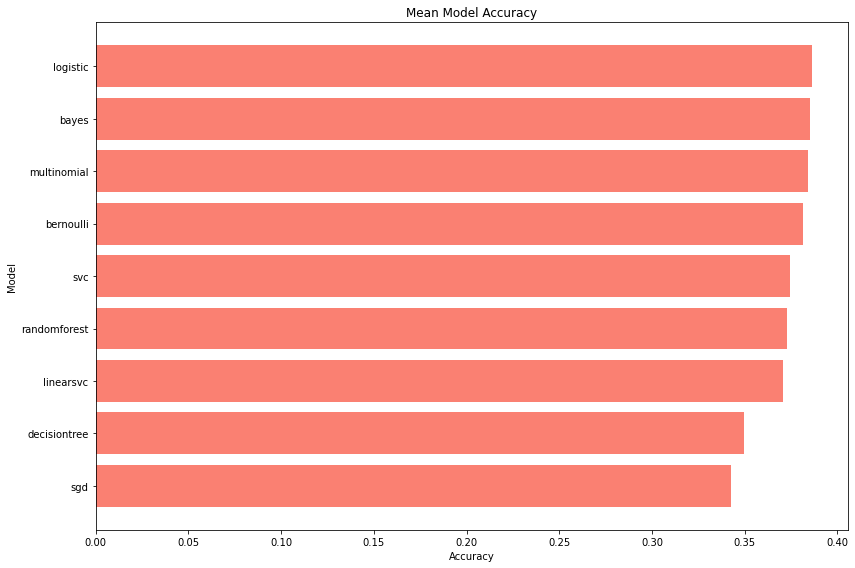

In [70]:
df_model = df.groupby(['model']).agg({'Accuracy':'mean'}).reset_index()
df_model = df_model.sort_values('Accuracy', ascending=False)

fig = plt.figure(figsize = (12, 8))
 
# creating the bar plot
plt.barh('model', 'Accuracy', data=df_model.sort_values('Accuracy', ascending=True), color ='salmon')#, height = 0.4)
 
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Mean Model Accuracy')
fig.tight_layout()
#plt.show()
plt.savefig(output_path+'Top_Models_Mean.png')

In [75]:
df.head(10)

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
586,logistic_bow_all_token_preprocess,0.5200,logistic,bow,all,None,preprocess
514,logistic_inquirer_all_token_preprocess,0.5200,logistic,inquirer,all,None,preprocess
192,bernoulli_pos_all_token,0.5200,bernoulli,pos,all,None,None
10,logistic_bigrambow_all_token_preprocess,0.5200,logistic,bigrambow,all,None,preprocess
152,logistic_pos_all_token,0.5167,logistic,pos,all,None,None
554,bernoulli_inquirer_all_token_preprocess,0.5167,bernoulli,inquirer,all,None,preprocess
202,multinomial_pos_all_token_preprocess,0.5167,multinomial,pos,all,None,preprocess
274,multinomial_negative_all_token_preprocess,0.5167,multinomial,negative,all,None,preprocess
288,bayes_subjectivity_all_token,0.5167,bayes,subjectivity,all,None,None
626,bernoulli_bow_all_token_preprocess,0.5167,bernoulli,bow,all,None,preprocess


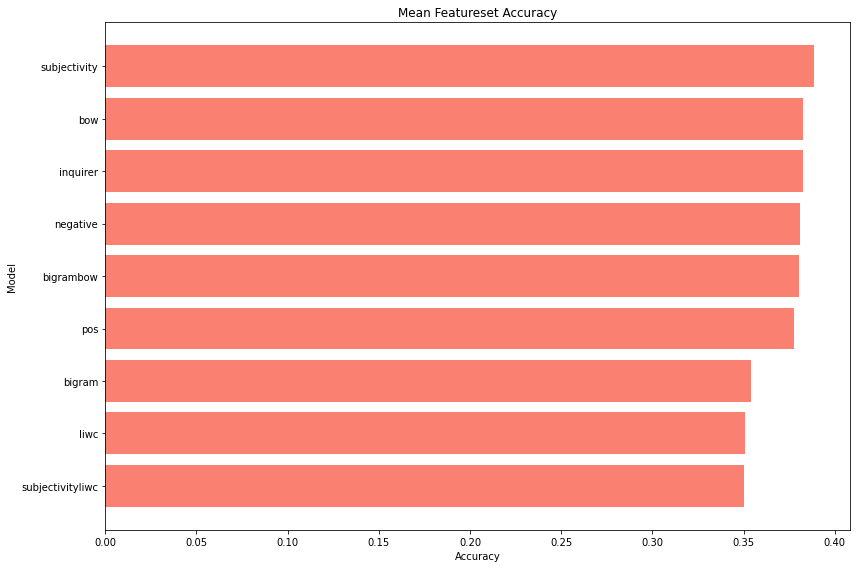

In [73]:
df_feature = df.groupby(['feature_set']).agg({'Accuracy':'mean'}).reset_index()
df_feature = df_feature.sort_values('Accuracy', ascending=False)

fig = plt.figure(figsize = (12, 8))
 
# creating the bar plot
plt.barh('feature_set', 'Accuracy', data=df_feature.sort_values('Accuracy', ascending=True), color ='salmon')#, height = 0.4)
 
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Mean Featureset Accuracy')
fig.tight_layout()
#plt.show()
plt.savefig(output_path+'Top_Featureset_Mean.png')

In [74]:
df_feature

,feature_set,Accuracy
7,subjectivity,0.388657
2,bow,0.382683
3,inquirer,0.382547
5,negative,0.381024
1,bigrambow,0.380329
6,pos,0.377501
0,bigram,0.354015
4,liwc,0.350543
8,subjectivityliwc,0.350267


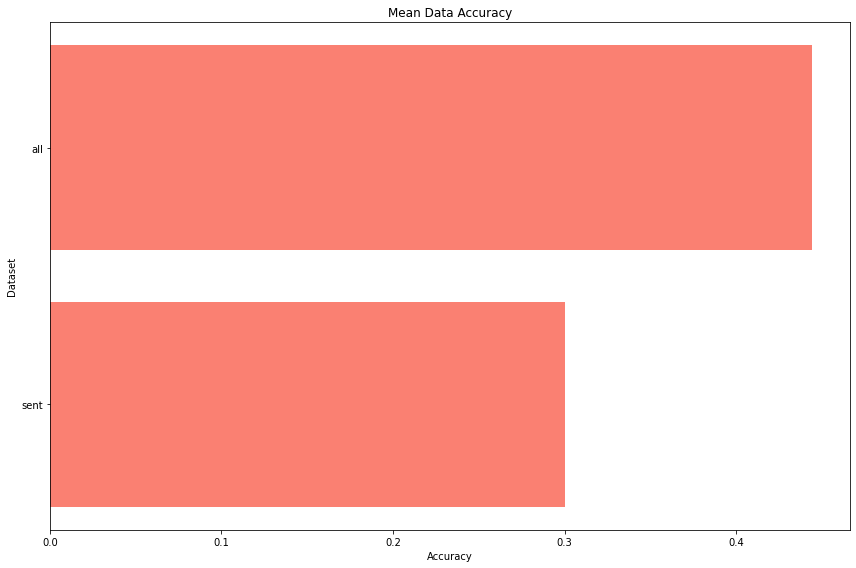

In [103]:
df_data = df.groupby(['processed_data']).agg({'Accuracy':'mean'}).reset_index()
df_data = df_data.sort_values('Accuracy', ascending=False)

fig = plt.figure(figsize = (12, 8))
 
# creating the bar plot
plt.barh('processed_data', 'Accuracy', data=df_data.sort_values('Accuracy', ascending=True), color ='salmon')#, height = 0.4)
 
plt.xlabel('Accuracy')
plt.ylabel('Dataset')
plt.title('Mean Data Accuracy')
fig.tight_layout()
#plt.show()
plt.savefig(output_path+'Data_Comparison.png')

In [163]:
df_data

,processed_data,Accuracy
0,all,0.443773
1,sent,0.300131


In [77]:
df[df['model']=='bayes'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
288,bayes_subjectivity_all_token,0.5167,bayes,subjectivity,all,None,None
506,bayes_inquirer_all_token_preprocess,0.5067,bayes,inquirer,all,None,preprocess
216,bayes_negative_all_token,0.5067,bayes,negative,all,None,None
2,bayes_bigrambow_all_token_preprocess,0.5067,bayes,bigrambow,all,None,preprocess
578,bayes_bow_all_token_preprocess,0.5067,bayes,bow,all,None,preprocess


In [78]:
df[df['model']=='logistic'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
586,logistic_bow_all_token_preprocess,0.5200,logistic,bow,all,None,preprocess
514,logistic_inquirer_all_token_preprocess,0.5200,logistic,inquirer,all,None,preprocess
10,logistic_bigrambow_all_token_preprocess,0.5200,logistic,bigrambow,all,None,preprocess
152,logistic_pos_all_token,0.5167,logistic,pos,all,None,None
154,logistic_pos_all_token_preprocess,0.5133,logistic,pos,all,None,preprocess


In [79]:
df[df['model']=='randomforest'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
90,randomforest_bigram_all_token_preprocess,0.5033,randomforest,bigram,all,None,preprocess
88,randomforest_bigram_all_token,0.5033,randomforest,bigram,all,None,None
376,randomforest_liwc_all_token,0.5033,randomforest,liwc,all,None,None
378,randomforest_liwc_all_token_preprocess,0.5033,randomforest,liwc,all,None,preprocess
450,randomforest_subjectivityliwc_all_token_prepro...,0.5033,randomforest,subjectivityliwc,all,None,preprocess


In [80]:
df[df['model']=='svc'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
314,svc_subjectivity_all_token_preprocess,0.5133,svc,subjectivity,all,None,preprocess
312,svc_subjectivity_all_token,0.5133,svc,subjectivity,all,None,None
530,svc_inquirer_all_token_preprocess,0.5100,svc,inquirer,all,None,preprocess
242,svc_negative_all_token_preprocess,0.5100,svc,negative,all,None,preprocess
602,svc_bow_all_token_preprocess,0.5100,svc,bow,all,None,preprocess


In [81]:
df[df['model']=='linearsvc'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
394,linearsvc_liwc_all_token_preprocess,0.5033,linearsvc,liwc,all,None,preprocess
106,linearsvc_bigram_all_token_preprocess,0.5033,linearsvc,bigram,all,None,preprocess
104,linearsvc_bigram_all_token,0.5033,linearsvc,bigram,all,None,None
392,linearsvc_liwc_all_token,0.5033,linearsvc,liwc,all,None,None
466,linearsvc_subjectivityliwc_all_token_preprocess,0.5033,linearsvc,subjectivityliwc,all,None,preprocess


In [82]:
df[df['model']=='sgd'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
400,sgd_liwc_all_token,0.5033,sgd,liwc,all,None,None
112,sgd_bigram_all_token,0.5033,sgd,bigram,all,None,None
114,sgd_bigram_all_token_preprocess,0.5033,sgd,bigram,all,None,preprocess
402,sgd_liwc_all_token_preprocess,0.5033,sgd,liwc,all,None,preprocess
472,sgd_subjectivityliwc_all_token,0.5033,sgd,subjectivityliwc,all,None,None


In [83]:
df[df['model']=='bernoulli'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
192,bernoulli_pos_all_token,0.5200,bernoulli,pos,all,None,None
554,bernoulli_inquirer_all_token_preprocess,0.5167,bernoulli,inquirer,all,None,preprocess
626,bernoulli_bow_all_token_preprocess,0.5167,bernoulli,bow,all,None,preprocess
624,bernoulli_bow_all_token,0.5133,bernoulli,bow,all,None,None
336,bernoulli_subjectivity_all_token,0.5133,bernoulli,subjectivity,all,None,None


In [84]:
df[df['model']=='multinomial'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
202,multinomial_pos_all_token_preprocess,0.5167,multinomial,pos,all,None,preprocess
274,multinomial_negative_all_token_preprocess,0.5167,multinomial,negative,all,None,preprocess
58,multinomial_bigrambow_all_token_preprocess,0.5100,multinomial,bigrambow,all,None,preprocess
416,multinomial_liwc_all_token,0.5033,multinomial,liwc,all,None,None
130,multinomial_bigram_all_token_preprocess,0.5033,multinomial,bigram,all,None,preprocess


In [85]:
df[df['model']=='decisiontree'].head()

,Featureset,Accuracy,model,feature_set,processed_data,filter,preprocess
138,decisiontree_bigram_all_token_preprocess,0.5033,decisiontree,bigram,all,None,preprocess
136,decisiontree_bigram_all_token,0.5033,decisiontree,bigram,all,None,None
426,decisiontree_liwc_all_token_preprocess,0.5033,decisiontree,liwc,all,None,preprocess
424,decisiontree_liwc_all_token,0.5033,decisiontree,liwc,all,None,None
498,decisiontree_subjectivityliwc_all_token_prepro...,0.5033,decisiontree,subjectivityliwc,all,None,preprocess


### Cross Validation

##### Best Model and Featureset

In [87]:
# Reading in dictionary
with open(output_path+"bigram_bow_dict.json", 'r') as infile:
    bigrambow_dict = json.load(infile)

In [173]:
num_folds = 10
label_list = list(range(0,5))
classifier_model = SklearnClassifier(LogisticRegression(max_iter=1000))

train_num = int(len(bigrambow_dict['bigrambow_all_token']) * 0.7)
train_set, test_set = bigrambow_dict['bigrambow_all_token'][:train_num], bigrambow_dict['bigrambow_all_token'][train_num:]

cross_validation_PRF(num_folds, train_set, test_set, label_list, classifier_model)

Each fold size for train: 70
Each fold size for test: 30
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9

Average Precision	Recall		F1 	Per Label
0 	      0.077      0.333      0.125
1 	      0.125      0.240      0.164
2 	      0.861      0.575      0.690
3 	      0.182      0.279      0.220
4 	      0.045      0.333      0.080

Macro Average Precision	Recall		F1 	Over All Labels
	      0.258      0.352      0.256

Label Counts {0: 55, 1: 176, 2: 481, 3: 220, 4: 68}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.483      0.421      0.421


##### Second Best Model and Featureset

In [174]:
# Reading in dictionary
with open(output_path+"pos_dict.json", 'r') as infile:
    pos_dict = json.load(infile)

In [175]:
num_folds = 10
label_list = list(range(0,5))
classifier_model = SklearnClassifier(BernoulliNB())

train_num = int(len(pos_dict['pos_all_token']) * 0.7)
train_set, test_set = pos_dict['pos_all_token'][:train_num], pos_dict['pos_all_token'][train_num:]

cross_validation_PRF(num_folds, train_set, test_set, label_list, classifier_model)

Each fold size for train: 70
Each fold size for test: 30
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9

Average Precision	Recall		F1 	Per Label
0 	      0.000      0.000      0.000
1 	      0.188      0.562      0.281
2 	      0.921      0.570      0.704
3 	      0.121      0.216      0.155
4 	      0.000      0.000      0.000

Macro Average Precision	Recall		F1 	Over All Labels
	      0.246      0.270      0.228

Label Counts {0: 55, 1: 176, 2: 481, 3: 220, 4: 68}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.502      0.421      0.422


##### Third Best Model and Featureset

In [176]:
# Reading in dictionary
with open(output_path+"inquirer_dict.json", 'r') as infile:
    inquirer_dict = json.load(infile)

In [177]:
num_folds = 10
label_list = list(range(0,5))
classifier_model = SklearnClassifier(LogisticRegression(max_iter=1000))

train_num = int(len(inquirer_dict['inquirer_all_token_preprocess']) * 0.7)
train_set, test_set = inquirer_dict['inquirer_all_token_preprocess'][:train_num], inquirer_dict['inquirer_all_token_preprocess'][train_num:]

cross_validation_PRF(num_folds, train_set, test_set, label_list, classifier_model)

Each fold size for train: 70
Each fold size for test: 30
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9

Average Precision	Recall		F1 	Per Label
0 	      0.000      0.000      0.000
1 	      0.208      0.345      0.260
2 	      0.848      0.593      0.698
3 	      0.242      0.340      0.283
4 	      0.091      0.400      0.148

Macro Average Precision	Recall		F1 	Over All Labels
	      0.278      0.336      0.278

Label Counts {0: 55, 1: 176, 2: 481, 3: 220, 4: 68}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.504      0.448      0.454


### Cross Validation: Testing Dataset

In [191]:
df_test_all = pd.read_csv(corpus_path+'test.tsv', sep='\t')
df_test_sentiments = pd.read_csv('/content/drive/MyDrive/IST 664 Project/Data/kagglemoviereviews/corpus/sampleSubmission.csv')

In [192]:
df_test = pd.merge(df_test_all, df_test_sentiments, on='PhraseId')

In [193]:
df_test = df_test[['Phrase', 'Sentiment']]

In [194]:
# Creating an empty list for the review data
test_data = []

# Looping through each line in the dataframe
for i, row in df_test['Phrase'].items():
  # Removing whitespace in each line
  row = row.strip()
  # Finding sentiment rating
  sentiment_rating = df_test.at[i, 'Sentiment']
  # Combine row and sentiment
  phrase_sentiment = row + '\t' + str(sentiment_rating)
  # Splitting each line by the separator and taking the phrase and sentiment
  test_data.append(phrase_sentiment.split('\t')[0:2])

# Shuffling the data for randomized documents
random.Random(3).shuffle(test_data)

In [195]:
test_all_preprocess = preprocess_text(test_data)[:300]

Random data used: 55802


In [196]:
all_words_list = [word for (sent,cat) in test_all_preprocess for word in sent]
all_words = nltk.FreqDist(all_words_list)
word_items = all_words.most_common(1000)
word_features = [word for (word,count) in word_items]

In [197]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_words_list)

In [198]:
bigram_features = finder.nbest(bigram_measures.chi_sq, 1000)

In [199]:
def bigram_document_features_test(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
    return features

In [200]:
test_set = [(bigram_document_features_test(d, word_features, bigram_features), c) for (d, c) in test_all_preprocess]

In [201]:
train_set = bigrambow_dict['bigrambow_all_token']

In [202]:
num_folds = 10
label_list = list(range(0,5))
classifier_model = SklearnClassifier(LogisticRegression(max_iter=1000))

cross_validation_PRF(num_folds, train_set, test_set, label_list, classifier_model)  

Each fold size for train: 100
Each fold size for test: 30
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9

Average Precision	Recall		F1 	Per Label
0 	      0.000      0.000      0.000
1 	      0.000      0.000      0.000
2 	      0.000      0.000      0.000
3 	      0.000      0.000      0.000
4 	      0.000      0.000      0.000

Macro Average Precision	Recall		F1 	Over All Labels
	      0.000      0.000      0.000

Label Counts {0: 55, 1: 176, 2: 781, 3: 220, 4: 68}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.000      0.000      0.000
